Тетрадка для предобработки данных.

# Import

In [69]:
import os
from dotenv import load_dotenv
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, StandardScaler, LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder

import category_encoders as ce

import torch
from torch.utils.data import Dataset


load_dotenv()
sklearn.set_config(transform_output="pandas")

# Config

In [70]:
INPUT_DATA_PATH = os.getenv("INPUT_DATA_PATH")
OUTPUT_DATA_PATH = os.getenv("OUTPUT_DATA_PATH")

# Classes and functions

Реализация класса для работы с данными ([документация](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)).

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, dataset_path: str, label_name: str, transform: Pipeline = None, target_transform: Pipeline = None):
        dataset = pd.read_csv(dataset_path)
        self.X, self.y = dataset.drop(label_name, axis=1), dataset[label_name]
        self.transform = transform
        self.target_transform = target_transform

        if self.transform:
            self.X = self.transform.fit_transform(self.X)
        
        if self.target_transform:
            self.y = self.target_transform.fit_transform(self.y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X.iloc[idx], self.y.iloc[idx]
    
    def _preprocess(self):
        pass

Вспомогательные функции.

In [71]:
def hour_to_weekday(hour):
    day = hour // 24
    weekday = day % 7
    return weekday


def hour_to_hour(hour):
    return hour % 24

# EDA

In [3]:
user_ds_path = os.path.join(INPUT_DATA_PATH, "Предсказание количества просмотров рекламы/users.tsv")
history_ds_path = os.path.join(INPUT_DATA_PATH, "Предсказание количества просмотров рекламы/history.tsv")
validate_ds_path = os.path.join(INPUT_DATA_PATH, "Предсказание количества просмотров рекламы/validate.tsv")

validate_answers_ds_path = os.path.join(INPUT_DATA_PATH, "Предсказание количества просмотров рекламы/validate_answers.tsv")

In [62]:
user_ds = pd.read_csv(user_ds_path, sep="\t")
history_ds = pd.read_csv(history_ds_path, sep="\t")
validate_ds = pd.read_csv(validate_ds_path, sep="\t")

validate_answers_ds = pd.read_csv(validate_answers_ds_path, sep="\t")

## Missed values

In [35]:
user_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27769 entries, 0 to 27768
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  27769 non-null  int64
 1   sex      27769 non-null  int64
 2   age      27769 non-null  int64
 3   city_id  27769 non-null  int64
dtypes: int64(4)
memory usage: 867.9 KB


In [36]:
history_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1147857 entries, 0 to 1147856
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   hour       1147857 non-null  int64  
 1   cpm        1147857 non-null  float64
 2   publisher  1147857 non-null  int64  
 3   user_id    1147857 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 35.0 MB


In [37]:
validate_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cpm            1008 non-null   float64
 1   hour_start     1008 non-null   int64  
 2   hour_end       1008 non-null   int64  
 3   publishers     1008 non-null   object 
 4   audience_size  1008 non-null   int64  
 5   user_ids       1008 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 47.4+ KB


In [38]:
validate_answers_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   at_least_one    1008 non-null   float64
 1   at_least_two    1008 non-null   float64
 2   at_least_three  1008 non-null   float64
dtypes: float64(3)
memory usage: 23.8 KB


___
В данных нет None значений, но нужно исследовать значения признаков.

## Values analyse

### users.tsv

In [5]:
user_ds.head()

,user_id,sex,age,city_id
0,0,2,19,0
1,1,1,0,1
2,2,2,24,2
3,3,1,20,3
4,4,2,29,4


In [10]:
len(user_ds) == len(user_ds["user_id"].unique())

True

In [12]:
np.unique(user_ds["sex"], return_counts=True)

(array([0, 1, 2]), array([   30, 14515, 13224]))

In [38]:
len(user_ds[user_ds["age"] == 0])

2180

In [40]:
len(user_ds[user_ds["city_id"] == 0])

8479

Text(0, 0.5, 'count')

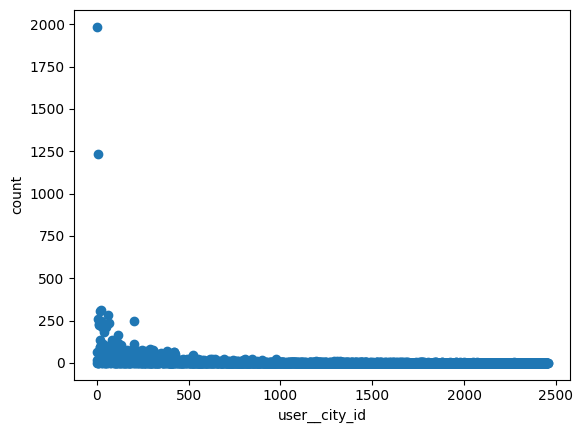

In [109]:
uniq_users_city_id = np.unique(user_ds[user_ds["city_id"] != 0]["city_id"], return_counts=True)

plt.scatter(uniq_users_city_id[0], uniq_users_city_id[1])
plt.xlabel("user__city_id")
plt.ylabel("count")

### history.tsv

In [41]:
history_ds.head()

,hour,cpm,publisher,user_id
0,10,30.00,1,15661
1,8,41.26,1,8444
2,7,360.00,1,15821
3,18,370.00,1,21530
4,8,195.00,2,22148


In [44]:
round(history_ds[["hour", "cpm"]].describe(), 2)

,hour,cpm
count,1147857.00,1147857.00
mean,760.30,186.40
std,430.62,455.73
min,3.00,30.00
25%,392.00,55.00
50%,762.00,110.00
75%,1138.00,210.00
max,1490.00,209053.98


Text(0.5, 0, 'history__hour')

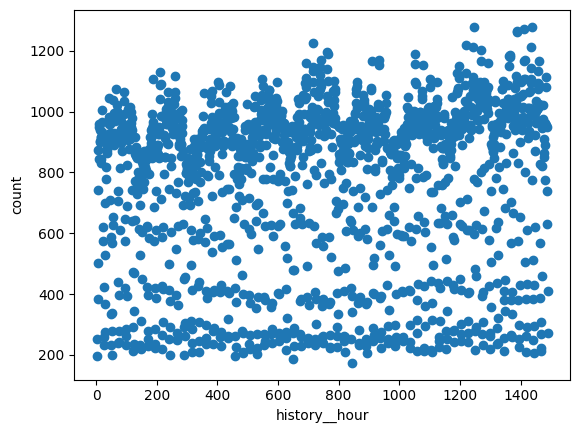

In [ ]:
plt.scatter(history_ds["hour"].value_counts().index, history_ds["hour"].value_counts().values)
plt.xlabel("history__hour")
plt.ylabel("count")

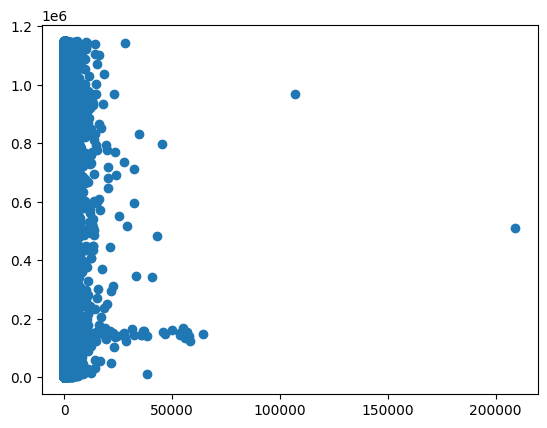

In [47]:
plt.scatter(history_ds["cpm"], history_ds.index)

Text(0, 0.5, 'count')

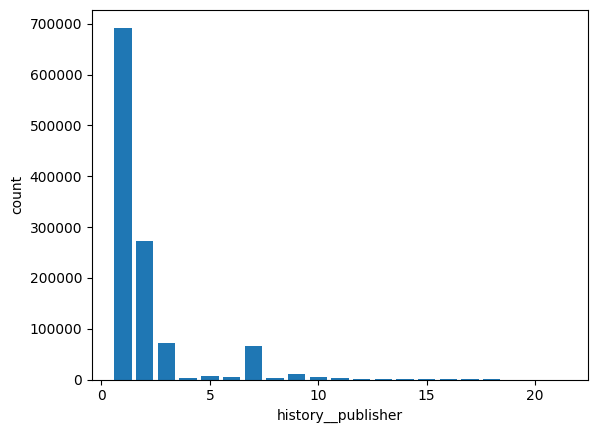

In [75]:
uniq_history_publisher = np.unique(history_ds["publisher"], return_counts=True)

fig, ax = plt.subplots()
ax.bar(uniq_history_publisher[0], uniq_history_publisher[1])
ax.set_xlabel("history__publisher")
ax.set_ylabel("count")

Text(0, 0.5, 'count')

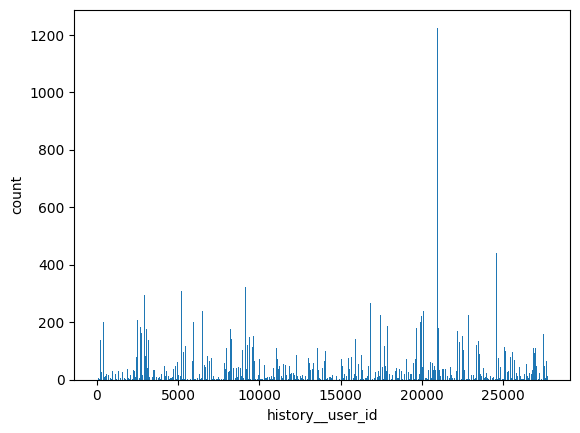

In [80]:
uniq_history_user_id = np.unique(history_ds["user_id"], return_counts=True)

fig, ax = plt.subplots()
ax.bar(uniq_history_user_id[0], uniq_history_user_id[1])
ax.set_xlabel("history__user_id")
ax.set_ylabel("count")

### validate.tsv

In [100]:
validate_ds["len_publishers"] = validate_ds["publishers"].apply(lambda x: len([int(v) for v in x.split(",")]))
validate_ds.head()

,cpm,hour_start,hour_end,publishers,audience_size,user_ids,len_publishers
0,220.0,1058,1153,"7,17",1906,"12,44,46,50,58,71,93,122,134,143,176,184,187,1...",2
1,312.0,1295,1301,"3,18",1380,"29,81,98,102,165,167,195,205,218,231,242,263,3...",2
2,70.0,1229,1249,"1,2,3,9,15,21",888,"12,23,25,29,45,85,92,124,156,190,272,334,456,5...",6
3,240.0,1295,1377,"1,14",440,"44,122,187,209,242,255,312,345,382,465,513,524...",2
4,262.0,752,990,"1,3,7,8",1476,"15,24,30,43,50,53,96,105,159,168,181,190,196,2...",4


In [83]:
round(validate_ds[["cpm", "audience_size"]].describe(), 2)

,cpm,audience_size
count,1008.00,1008.00
mean,162.43,1090.09
std,112.19,613.56
min,30.00,300.00
25%,79.00,575.00
50%,130.00,960.00
75%,220.00,1464.00
max,475.00,2500.00


Text(0, 0.5, 'count')

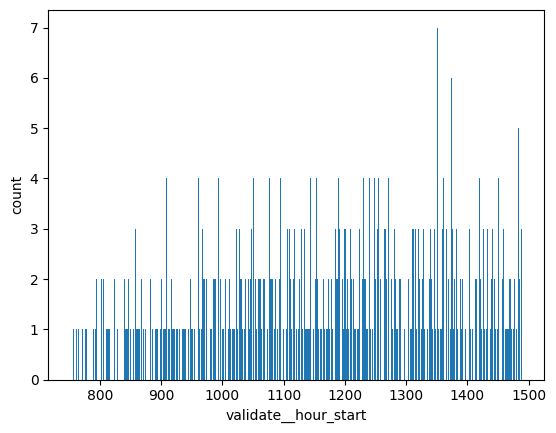

In [86]:
uniq_validate_hour_start = np.unique(validate_ds["hour_end"], return_counts=True)

fig, ax = plt.subplots()
ax.bar(uniq_validate_hour_start[0], uniq_validate_hour_start[1])
ax.set_xlabel("validate__hour_start")
ax.set_ylabel("count")

Text(0, 0.5, 'count')

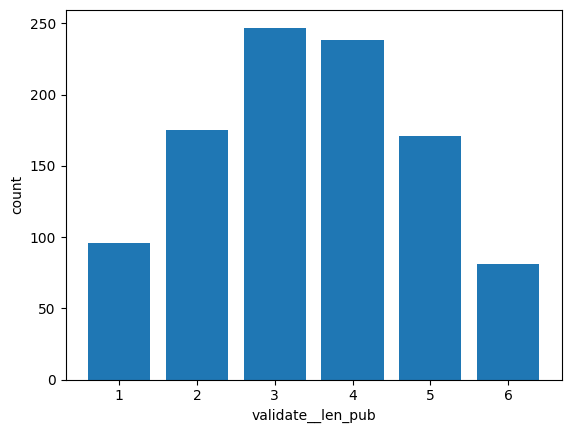

In [98]:
uniq_validate_len_pub = np.unique(validate_ds["len_publishers"], return_counts=True)

fig, ax = plt.subplots()
ax.bar(uniq_validate_len_pub[0], uniq_validate_len_pub[1])
ax.set_xlabel("validate__len_pub")
ax.set_ylabel("count")

### conclusion

___
**users.tsv:**
- все пользователи уникальные,
- 30 пользователей без пола, примерно 50/50,
- 2180 пропущено возрастов, есть люди страше 90 лет,
- 84790 пропущено городов, город с id=3 концентрирует в себе пользователей.

**history.tsv:**
- два выброса по cpm,
- есть периодичность по времени,
- все просмотры сконцентрированы на 4 площадках,
- два пользователя смотрят очень много объявлений (мб выбросы и стоит обрезать).

**validate.tsv:**
- максимум используется 6 площадок, в основном 3-4.

## Feature engineering

### user.tsv - Age

Мб есть люди, которые возраст поставили наугад.

Разобьем людей на возрастные группы и посмотрим на их статистики. Мб группы будут пересекаться.

In [5]:
none_age_users = user_ds[user_ds["age"] == 0]
full_age_users = user_ds[user_ds["age"] != 0]

In [6]:
# Добавляем столбец с временными метками
# (по ним можно узнать: сколько раз пользователь видел объявления и в какое время)
none_age_users["hours"] = none_age_users["user_id"].apply(lambda x: history_ds[history_ds["user_id"] == x]["hour"].unique())
full_age_users["hours"] = full_age_users["user_id"].apply(lambda x: history_ds[history_ds["user_id"] == x]["hour"].unique())

/tmp/ipykernel_1769335/3198654064.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  none_age_users["hours"] = none_age_users["user_id"].apply(lambda x: history_ds[history_ds["user_id"] == x]["hour"].unique())
/tmp/ipykernel_1769335/3198654064.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_age_users["hours"] = full_age_users["user_id"].apply(lambda x: history_ds[history_ds["user_id"] == x]["hour"].unique())


In [7]:
# Добавляем столбец с площадками
# (можно посмотреть на каких площадках сидит пользователь)
none_age_users["publishers"] = none_age_users["user_id"].apply(lambda x: history_ds[history_ds["user_id"] == x]["publisher"].unique())
full_age_users["publishers"] = full_age_users["user_id"].apply(lambda x: history_ds[history_ds["user_id"] == x]["publisher"].unique())

/tmp/ipykernel_1769335/636257355.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  none_age_users["publishers"] = none_age_users["user_id"].apply(lambda x: history_ds[history_ds["user_id"] == x]["publisher"].unique())
/tmp/ipykernel_1769335/636257355.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_age_users["publishers"] = full_age_users["user_id"].apply(lambda x: history_ds[history_ds["user_id"] == x]["publisher"].unique())


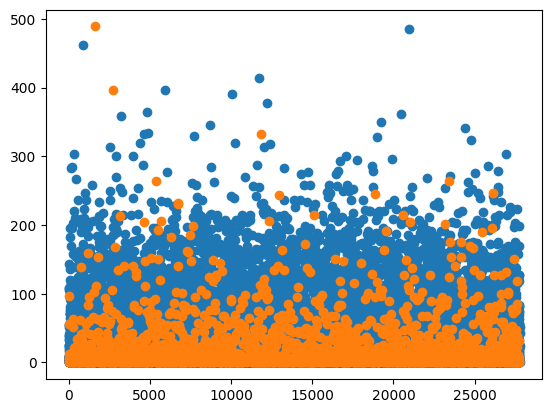

In [12]:
plt.scatter(full_age_users["user_id"], full_age_users["hours"].apply(lambda x: len(x)))
plt.scatter(none_age_users["user_id"], none_age_users["hours"].apply(lambda x: len(x)))

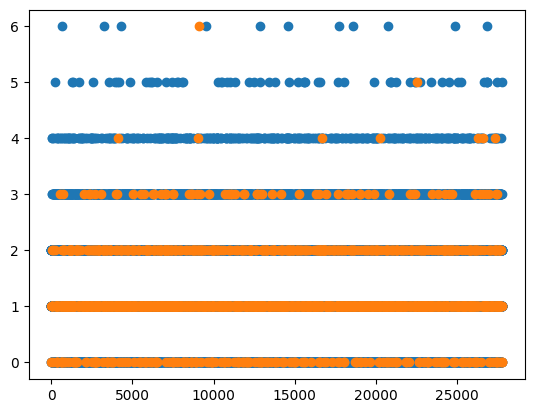

In [13]:
plt.scatter(full_age_users["user_id"], full_age_users["publishers"].apply(lambda x: len(x)))
plt.scatter(none_age_users["user_id"], none_age_users["publishers"].apply(lambda x: len(x)))

In [ ]:
# Какие статистики у none_age_users
none_age_users["len_hours"] = none_age_users["hours"].apply(lambda x: len(x))
none_age_users["len_publishers"] = none_age_users["publishers"].apply(lambda x: len(x))

/tmp/ipykernel_1769335/44707648.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  none_age_users["len_publishers"] = none_age_users["publishers"].apply(lambda x: len(x))


In [37]:
round(none_age_users[["len_hours", "len_publishers"]].describe(), 2)

,len_hours,len_publishers
count,2180.00,2180.00
mean,22.36,1.18
std,39.43,0.65
min,0.00,0.00
25%,2.00,1.00
50%,6.00,1.00
75%,25.00,1.00
max,489.00,6.00


In [ ]:
# Берем людей кто использует 1-3 площадки и смотрит рекламу меньше 25 раз за два месяца
# full_age_users["len_hours"] = full_age_users["hours"].apply(lambda x: len(x))
# full_age_users["len_publishers"] = full_age_users["publishers"].apply(lambda x: len(x))

mask = ((full_age_users["len_hours"] < 25) & (full_age_users["len_publishers"] <= 3))
full_age_users_subset = full_age_users[mask]

In [40]:
round(full_age_users_subset["age"].describe(), 2)

count    16043.00
mean        32.01
std         17.36
min         13.00
25%         20.00
50%         29.00
75%         38.00
max        118.00
Name: age, dtype: float64

<Axes: >

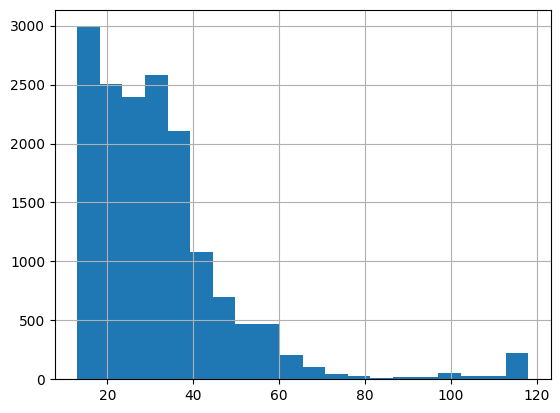

In [42]:
full_age_users_subset["age"].hist(bins=20)

In [141]:
# Заполняем пропущенные значения Age
add_user_ds = user_ds.copy()

mask = (add_user_ds["age"] == 0)
# 1 - с помощью среднего по всему датасету
# add_user_ds.loc[mask, "age"] = int(np.mean(add_user_ds[add_user_ds["age"] != 0]["age"]))

# 2 - с помощью среднего по выборке (из графика выше взял число имперически)
# add_user_ds.loc[mask, "age"] = 25

# 3 - с помощью косинусной схожести
new_ages = []
for i, row in tqdm(none_age_users.iterrows(), total=len(none_age_users)):
    sims = cosine_similarity([row[["sex", "city_id", "len_hours", "len_publishers"]]], full_age_users[["sex", "city_id", "len_hours", "len_publishers"]])
    sims = [True if sim == np.max(sims) else False for sim in sims[0]]
    age = int(np.mean(full_age_users.loc[sims, "age"]))
    new_ages.append(age)

add_user_ds.loc[mask, "age"] = new_ages

100%|██████████| 2180/2180 [07:28<00:00,  4.86it/s]


### user.tsv - Sex

In [156]:
add_user_ds.head()

,user_id,sex,age,city_id
0,0,2,19,0
1,1,1,38,1
2,2,2,24,2
3,3,1,20,3
4,4,2,29,4


In [157]:
none_sex_users = add_user_ds[add_user_ds["sex"] == 0]
full_sex_users = add_user_ds[add_user_ds["sex"] != 0]

In [ ]:
# 

## Form dataset

**Новые признаки:**
- доля женщин,
- доля людей до 38,
- доля людей из мегаполиса, города,
- среднее количество площадок у пользователей,
- топовая площадка,
- среднее время в которое просматривалась реклама,
- средняя цена рекламы,
- день недели в которое выставляется реклама,
- на сколько часов выставляется реклама.

**Убрать признаки:**
- user_ids,
- hour_end.

**Преобразование признаков:**
- publishers в количество площадок.

# Load data

In [72]:
user_ds_path = os.path.join(INPUT_DATA_PATH, "Предсказание количества просмотров рекламы/users.tsv")
history_ds_path = os.path.join(INPUT_DATA_PATH, "Предсказание количества просмотров рекламы/history.tsv")
validate_ds_path = os.path.join(INPUT_DATA_PATH, "Предсказание количества просмотров рекламы/validate.tsv")

validate_answers_ds_path = os.path.join(INPUT_DATA_PATH, "Предсказание количества просмотров рекламы/validate_answers.tsv")

In [73]:
user_ds = pd.read_csv(user_ds_path, sep="\t")
history_ds = pd.read_csv(history_ds_path, sep="\t")
validate_ds = pd.read_csv(validate_ds_path, sep="\t")

validate_answers_ds = pd.read_csv(validate_answers_ds_path, sep="\t")

temp

In [62]:
end_valid_ds_path = os.path.join(OUTPUT_DATA_PATH, "end_valid.tsv")
end_valid_ds = pd.read_csv(end_valid_ds_path, sep="\t")

In [65]:
round(end_valid_ds.describe(), 2)

,cpm,percent_man,count_pub,input_top_pub,count_group,input_top_group,count_day,input_top_time,input_top_day,at_least_one,at_least_two,at_least_three
count,1008.00,1008.00,1008.00,1008.00,1008.0,1008.00,1008.00,1008.00,1008.00,1008.00,1008.00,1008.00
mean,162.43,52.51,3.45,0.93,1.0,0.93,2.50,0.45,0.97,0.12,0.07,0.05
std,112.19,3.71,1.41,0.26,0.0,0.26,1.81,0.50,0.18,0.15,0.12,0.10
min,30.00,41.12,1.00,0.00,1.0,0.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,79.00,50.49,2.00,1.00,1.0,1.00,1.00,0.00,1.00,0.02,0.00,0.00
50%,130.00,52.31,3.00,1.00,1.0,1.00,2.00,0.00,1.00,0.06,0.01,0.00
75%,220.00,53.93,4.25,1.00,1.0,1.00,4.00,1.00,1.00,0.16,0.08,0.05
max,475.00,65.66,6.00,1.00,1.0,1.00,7.00,1.00,1.00,0.93,0.91,0.88


# Data cleaning and preparation

### Users

In [290]:
user_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27769 entries, 0 to 27768
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  27769 non-null  int64
 1   sex      27769 non-null  int64
 2   age      27769 non-null  int64
 3   city_id  27769 non-null  int64
dtypes: int64(4)
memory usage: 867.9 KB


In [291]:
round((user_ds[["sex", "age", "city_id"]] == 0).sum()/len(user_ds), 3)

sex        0.001
age        0.079
city_id    0.305
dtype: float64

### History

In [222]:
history_ds.isnull().sum()

hour         0
cpm          0
publisher    0
user_id      0
dtype: int64

In [223]:
history_ds["hour"].min(), history_ds["cpm"].min(), history_ds["publisher"].min()

(np.int64(3), np.float64(30.0), np.int64(1))

In [74]:
# Перевод часов в дни недели и в интервал [0-23]
history_ds["weekday"] = history_ds["hour"].apply(hour_to_weekday)
history_ds["hour"] = history_ds["hour"].apply(hour_to_hour)

### Validate

In [236]:
validate_ds.head()

,cpm,hour_start,hour_end,publishers,audience_size,user_ids
0,220.0,1058,1153,"7,17",1906,"12,44,46,50,58,71,93,122,134,143,176,184,187,1..."
1,312.0,1295,1301,"3,18",1380,"29,81,98,102,165,167,195,205,218,231,242,263,3..."
2,70.0,1229,1249,"1,2,3,9,15,21",888,"12,23,25,29,45,85,92,124,156,190,272,334,456,5..."
3,240.0,1295,1377,"1,14",440,"44,122,187,209,242,255,312,345,382,465,513,524..."
4,262.0,752,990,"1,3,7,8",1476,"15,24,30,43,50,53,96,105,159,168,181,190,196,2..."


In [241]:
validate_ds.dtypes

cpm              float64
hour_start         int64
hour_end           int64
publishers        object
audience_size      int64
user_ids          object
dtype: object

In [75]:
validate_ds["publishers"] = validate_ds["publishers"].apply(lambda publishers: [int(publisher) for publisher in publishers.split(",")])
validate_ds["user_ids"] = validate_ds["user_ids"].apply(lambda user_ids: [int(user_id) for user_id in user_ids.split(",")])

In [245]:
# Есть ли пропуски
min([len(publishers) for publishers in validate_ds["publishers"]]), min(validate_ds["audience_size"])

(1, 300)

In [76]:
# Переводим hour_start в день недели и суточный час, hour_end убираем и вместо него указываем длительность
validate_ds["weekday_start"] = validate_ds["hour_start"].apply(hour_to_weekday)
validate_ds["duration"] = validate_ds["hour_end"] - validate_ds["hour_start"]
validate_ds["hour_start"] = validate_ds["hour_start"].apply(hour_to_weekday)
validate_ds = validate_ds.drop(columns=["hour_end"])

In [77]:
# Создаем новый признак на основе publishers
validate_ds["group_quantity"] = validate_ds["publishers"].apply(lambda publishers: len(publishers))

In [13]:
validate_ds.head()

,cpm,hour_start,publishers,audience_size,user_ids,weekday_start,duration,group_quantity
0,220.0,2,"[7, 17]",1906,"[12, 44, 46, 50, 58, 71, 93, 122, 134, 143, 17...",2,95,2
1,312.0,4,"[3, 18]",1380,"[29, 81, 98, 102, 165, 167, 195, 205, 218, 231...",4,6,2
2,70.0,2,"[1, 2, 3, 9, 15, 21]",888,"[12, 23, 25, 29, 45, 85, 92, 124, 156, 190, 27...",2,20,6
3,240.0,4,"[1, 14]",440,"[44, 122, 187, 209, 242, 255, 312, 345, 382, 4...",4,82,2
4,262.0,3,"[1, 3, 7, 8]",1476,"[15, 24, 30, 43, 50, 53, 96, 105, 159, 168, 18...",3,238,4


### Validate_answers

In [14]:
validate_answers_ds.head()

,at_least_one,at_least_two,at_least_three
0,0.0430,0.0152,0.0073
1,0.0130,0.0000,0.0000
2,0.0878,0.0135,0.0000
3,0.2295,0.1295,0.0727
4,0.3963,0.2785,0.2270


In [78]:
# Переводим в количество просмотров
for i, row in validate_answers_ds.iterrows():
    audience_size = validate_ds.loc[i, "audience_size"]

    validate_answers_ds.loc[i, "at_least_one"] = round(audience_size*validate_answers_ds.loc[i, "at_least_one"])
    validate_answers_ds.loc[i, "at_least_two"] = round(audience_size*validate_answers_ds.loc[i, "at_least_two"])
    validate_answers_ds.loc[i, "at_least_three"] = round(audience_size*validate_answers_ds.loc[i, "at_least_three"])

validate_answers_ds = validate_answers_ds.apply(np.int64)

In [16]:
validate_answers_ds.head()

,at_least_one,at_least_two,at_least_three
0,82,29,14
1,18,0,0
2,78,12,0
3,101,57,32
4,585,411,335


# EDA

### Users

In [17]:
user_ds.head()

,user_id,sex,age,city_id
0,0,2,19,0
1,1,1,0,1
2,2,2,24,2
3,3,1,20,3
4,4,2,29,4


<Axes: xlabel='sex'>

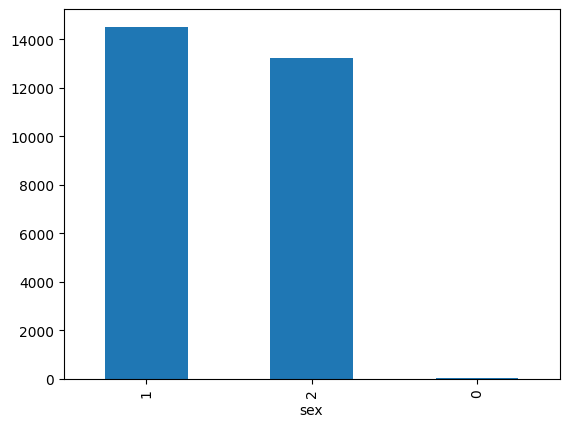

In [21]:
user_ds["sex"].value_counts().plot(kind="bar")

In [79]:
# Присваиваем всех нулевым значение 1
user_ds["sex"] = user_ds["sex"].replace(0, 1)
user_ds["sex"] = user_ds["sex"] - 1

In [80]:
# Создадим дополнительную таблицу для лучшего понимания распределения
add_user_ds = user_ds.copy()

add_data = {
    "publishers": [],
    "publisher_quantity": [],
    "hours": [],
    "weekdays": [],
    "views": []
}
for i, row in tqdm(add_user_ds.iterrows(), total=len(add_user_ds)):
    user_id = row["user_id"]

    add_data["publishers"].append(np.unique(history_ds[history_ds["user_id"] == user_id]["publisher"]))
    add_data["publisher_quantity"].append(len(add_data["publishers"][i]))
    add_data["hours"].append(list(history_ds[history_ds["user_id"] == user_id]["hour"]))
    add_data["weekdays"].append(list(history_ds[history_ds["user_id"] == user_id]["weekday"]))
    add_data["views"].append(len(add_data["hours"][i]))

add_user_ds = add_user_ds.assign(**add_data)

  0%|          | 0/27769 [00:00<?, ?it/s]

100%|██████████| 27769/27769 [00:56<00:00, 495.10it/s]


<Axes: >

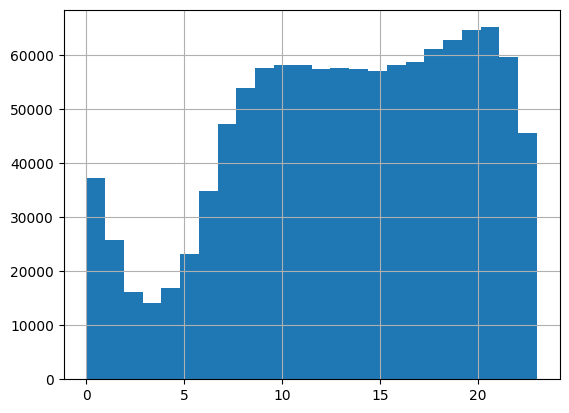

In [ ]:
# В какое время чаще всего засиживаются и в какой день недели
history_ds["hour"].hist(bins=24)

<Axes: >

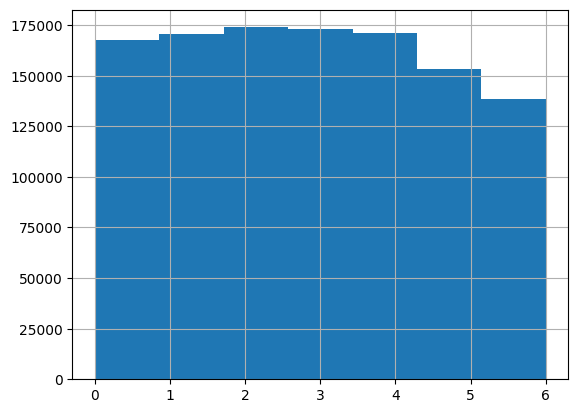

In [15]:
history_ds["weekday"].hist(bins=7)

По графикам выше видно что чаще всего заходят с 17 до 21, меньше всего с 22 до 6. В выходные тоже заходят меньше всего.

In [81]:
# Добавим категориальные признаки top_hour: ["22-7", "8-15", "16-21"], top_hour_ratio: float и is_weekend: float
new_data = {
    "top_time_interval": [],
    "top_time_interval_ratio": [],
    "is_workday": []
}
for i, row in tqdm(add_user_ds.iterrows(), total=len(add_user_ds)):
    if row["views"] == 0:
        new_data["top_time_interval"].append(None)
        new_data["top_time_interval_ratio"].append(None)
        new_data["is_workday"].append(None)
        continue

    hours, counts = np.unique(row["hours"], return_counts=True)
    intervals = {
        "22-7": (hours <= 7) | (hours >= 22),
        "8-15": (hours >= 8) & (hours <= 15),
        "16-21": (hours >= 16) & (hours <= 21),
    }
    interval_counts = {key: np.sum(counts[mask]) for key, mask in intervals.items()}

    top_time_interval = max(interval_counts, key=interval_counts.get)
    top_time_interval_ratio = interval_counts[top_time_interval]/np.sum(list(interval_counts.values()))

    weekdays, counts = np.unique(row["weekdays"], return_counts=True)
    intervals = {
        "0-4": (weekdays <= 4),
        "5-6": (weekdays >= 5)
    }
    interval_counts = {key: np.sum(counts[mask]) for key, mask in intervals.items()}

    is_workday = interval_counts["0-4"]/np.sum(list(interval_counts.values()))
    
    new_data["top_time_interval"].append(top_time_interval)
    new_data["top_time_interval_ratio"].append(top_time_interval_ratio)
    new_data["is_workday"].append(is_workday)

add_user_ds = add_user_ds.assign(**new_data)

100%|██████████| 27769/27769 [00:03<00:00, 8402.81it/s]


<Axes: xlabel='publisher'>

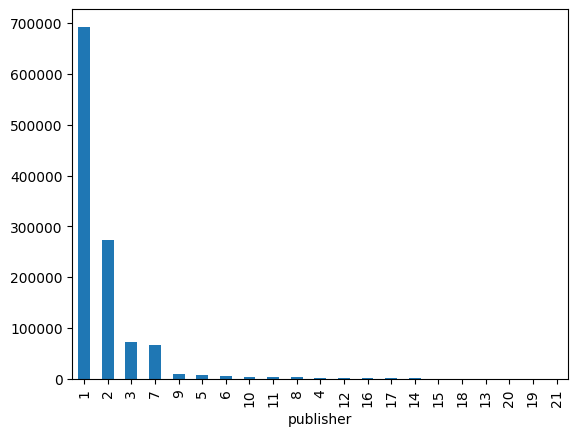

In [62]:
# Популярность площадок
history_ds["publisher"].value_counts().plot(kind="bar")

In [82]:
# Добавим категориальные признаки
# Есть ли популярная площадка top_publisher_type: ["well_done", "medium", "rare"]
# Доля популярной площадки top_publisher_type_ratio: float
new_data = {
    "top_publisher": [],
    "top_publisher_ratio": []
}
for i, row in tqdm(add_user_ds.iterrows(), total=len(add_user_ds)):
    if row["publisher_quantity"] == 0:
        new_data["top_publisher"].append(None)
        new_data["top_publisher_ratio"].append(None)
        continue

    publishers, counts = np.unique(row["publishers"], return_counts=True)
    intervals = {
        "well_done": (publishers <= 2),
        "medium": (publishers == 3) | (publishers == 7),
        "rare": (publishers == 4) | (publishers == 5) | (publishers == 6) | (publishers >= 8),
    }
    interval_counts = {key: np.sum(counts[mask]) for key, mask in intervals.items()}

    top_publisher = max(interval_counts, key=interval_counts.get)
    top_publisher_ratio = interval_counts[top_publisher]/np.sum(list(interval_counts.values()))

    new_data["top_publisher"].append(top_publisher)
    new_data["top_publisher_ratio"].append(top_publisher_ratio)

add_user_ds = add_user_ds.assign(**new_data)

100%|██████████| 27769/27769 [00:02<00:00, 12285.27it/s]


In [83]:
# Удаляем ненужные признаки
add_user_ds = add_user_ds.drop(columns=["publishers", "hours", "weekdays"])

In [16]:
add_user_ds.head()

,user_id,sex,age,city_id,publisher_quantity,views,top_time_interval,top_time_interval_ratio,is_workday,top_publisher,top_publisher_ratio
0,0,1,19,0,1,2,8-15,0.500000,1.000000,well_done,1.0
1,1,0,0,1,1,82,8-15,0.585366,0.597561,well_done,1.0
2,2,1,24,2,0,0,None,NaN,NaN,None,NaN
3,3,0,20,3,2,8,8-15,0.500000,0.750000,well_done,0.5
4,4,1,29,4,2,132,8-15,0.560606,0.848485,well_done,0.5


In [61]:
round(add_user_ds.isna().sum()/len(add_user_ds)*100, 2)

user_id                    0.00
sex                        0.00
age                        0.00
city_id                    0.00
publisher_quantity         0.00
views                      0.00
top_time_interval          8.04
top_time_interval_ratio    8.04
is_workday                 8.04
top_publisher              8.04
top_publisher_ratio        8.04
dtype: float64

<BarContainer object of 2457 artists>

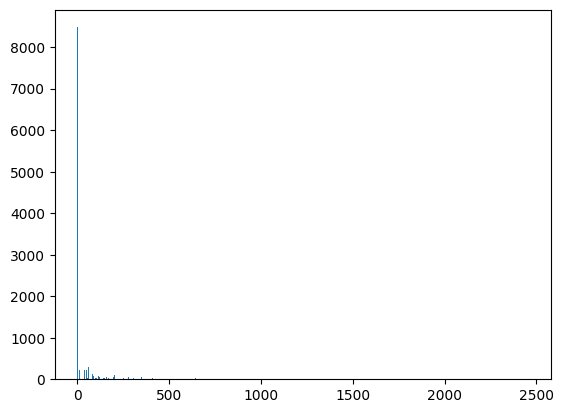

In [96]:
# Популярность городов
city_ids, counts = np.unique(add_user_ds["city_id"], return_counts=True)
plt.bar(city_ids, counts)

In [20]:
round((add_user_ds["city_id"] == 0).sum()/len(add_user_ds)*100, 2)

np.float64(30.53)

In [147]:
с_add_user_ds = add_user_ds.copy()

In [148]:
# Меняем категориальные признаки
encoder = ce.CountEncoder(cols=["city_id"])
с_add_user_ds = encoder.fit_transform(с_add_user_ds)
с_add_user_ds.head()

,user_id,sex,age,city_id,publisher_quantity,views,top_time_interval,top_time_interval_ratio,is_workday,top_publisher,top_publisher_ratio
0,0,1,19,8479,1,2,8-15,0.500000,1.000000,well_done,1.0
1,1,0,0,16,1,82,8-15,0.585366,0.597561,well_done,1.0
2,2,1,24,1,0,0,None,NaN,NaN,None,NaN
3,3,0,20,1985,2,8,8-15,0.500000,0.750000,well_done,0.5
4,4,1,29,66,2,132,8-15,0.560606,0.848485,well_done,0.5


In [149]:
encoder = ce.OneHotEncoder(cols=["top_time_interval"], use_cat_names=True, handle_missing="return_nan")
с_add_user_ds = encoder.fit_transform(с_add_user_ds)
с_add_user_ds.head()

,user_id,sex,age,city_id,publisher_quantity,views,top_time_interval_8-15,top_time_interval_16-21,top_time_interval_22-7,top_time_interval_ratio,is_workday,top_publisher,top_publisher_ratio
0,0,1,19,8479,1,2,1.0,0.0,0.0,0.500000,1.000000,well_done,1.0
1,1,0,0,16,1,82,1.0,0.0,0.0,0.585366,0.597561,well_done,1.0
2,2,1,24,1,0,0,NaN,NaN,NaN,NaN,NaN,None,NaN
3,3,0,20,1985,2,8,1.0,0.0,0.0,0.500000,0.750000,well_done,0.5
4,4,1,29,66,2,132,1.0,0.0,0.0,0.560606,0.848485,well_done,0.5


In [150]:
mapping = [{'col': 'top_publisher', 'mapping': {"well_done": 3, "medium": 2, "rare": 1}}]
encoder = ce.OrdinalEncoder(mapping=mapping, cols=["top_publisher"], drop_invariant=True, handle_missing="return_nan")
с_add_user_ds = encoder.fit_transform(с_add_user_ds)
с_add_user_ds.head()

,user_id,sex,age,city_id,publisher_quantity,views,top_time_interval_8-15,top_time_interval_16-21,top_time_interval_22-7,top_time_interval_ratio,is_workday,top_publisher,top_publisher_ratio
0,0,1,19,8479,1,2,1.0,0.0,0.0,0.500000,1.000000,3.0,1.0
1,1,0,0,16,1,82,1.0,0.0,0.0,0.585366,0.597561,3.0,1.0
2,2,1,24,1,0,0,NaN,NaN,NaN,NaN,NaN,-1.0,NaN
3,3,0,20,1985,2,8,1.0,0.0,0.0,0.500000,0.750000,3.0,0.5
4,4,1,29,66,2,132,1.0,0.0,0.0,0.560606,0.848485,3.0,0.5


In [151]:
# Переводим в int
с_add_user_ds = с_add_user_ds.replace({'top_publisher': -1}, np.nan)
с_add_user_ds = с_add_user_ds.astype({"top_time_interval_8-15": "Int64", "top_time_interval_16-21": "Int64", "top_time_interval_22-7": "Int64", "top_publisher": "Int64"})
с_add_user_ds.head()

,user_id,sex,age,city_id,publisher_quantity,views,top_time_interval_8-15,top_time_interval_16-21,top_time_interval_22-7,top_time_interval_ratio,is_workday,top_publisher,top_publisher_ratio
0,0,1,19,8479,1,2,1,0,0,0.500000,1.000000,3,1.0
1,1,0,0,16,1,82,1,0,0,0.585366,0.597561,3,1.0
2,2,1,24,1,0,0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,NaN
3,3,0,20,1985,2,8,1,0,0,0.500000,0.750000,3,0.5
4,4,1,29,66,2,132,1,0,0,0.560606,0.848485,3,0.5


<Axes: >

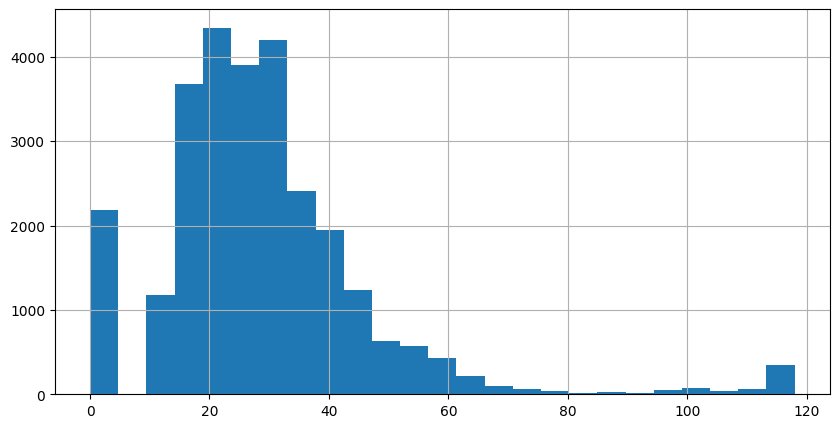

In [152]:
с_add_user_ds["age"].hist(bins=25, figsize=(10, 5))

In [153]:
# Убираем выбросы: кто старше 90 тому присваиваем mean
mask = ((с_add_user_ds["age"] != 0) & (с_add_user_ds["age"] < 90))
mean_age = np.mean(с_add_user_ds.loc[mask, "age"]).astype(np.int64)

mask = с_add_user_ds["age"] >= 90
с_add_user_ds.loc[mask, "age"] = mean_age

<Axes: >

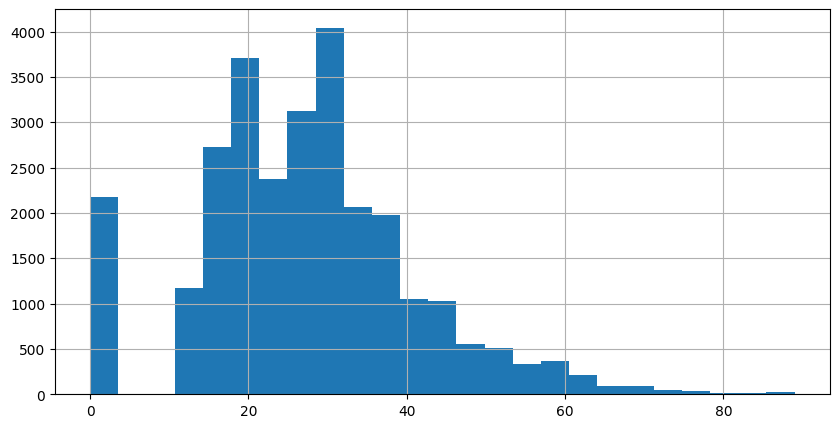

In [154]:
с_add_user_ds["age"].hist(bins=25, figsize=(10, 5))

In [155]:
# Возьмем юзеров без пропущенных значений
c_add_user_ds_subset = с_add_user_ds[с_add_user_ds["views"] != 0]
c_add_user_ds_subset.head()

,user_id,sex,age,city_id,publisher_quantity,views,top_time_interval_8-15,top_time_interval_16-21,top_time_interval_22-7,top_time_interval_ratio,is_workday,top_publisher,top_publisher_ratio
0,0,1,19,8479,1,2,1,0,0,0.500000,1.000000,3,1.0
1,1,0,0,16,1,82,1,0,0,0.585366,0.597561,3,1.0
3,3,0,20,1985,2,8,1,0,0,0.500000,0.750000,3,0.5
4,4,1,29,66,2,132,1,0,0,0.560606,0.848485,3,0.5
5,5,1,22,20,1,9,1,0,0,0.888889,0.666667,2,1.0


<Axes: >

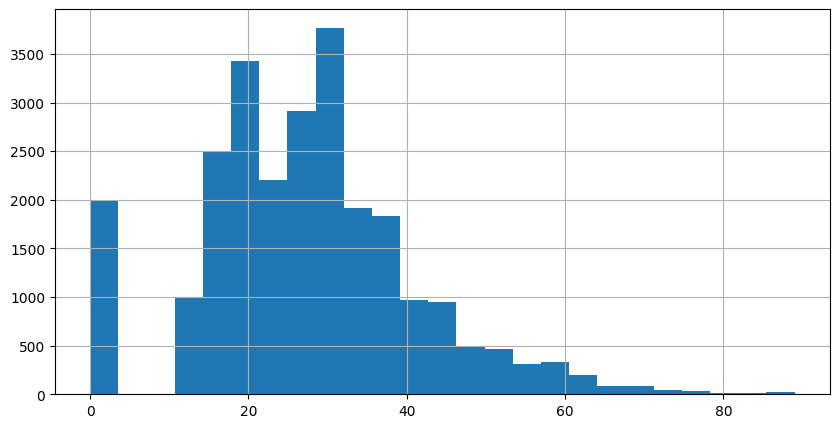

In [156]:
c_add_user_ds_subset["age"].hist(bins=25, figsize=(10, 5))

In [157]:
# Присвоим None к возрасту и заполним их
c_add_user_ds_subset = c_add_user_ds_subset.replace({"age": 0}, np.nan)

imputer = KNNImputer(n_neighbors=5, weights="uniform")
c_add_user_ds_subset["age"] = imputer.fit_transform(c_add_user_ds_subset.drop(columns=["user_id"]))["age"].astype(np.int64)
c_add_user_ds_subset.head()

,user_id,sex,age,city_id,publisher_quantity,views,top_time_interval_8-15,top_time_interval_16-21,top_time_interval_22-7,top_time_interval_ratio,is_workday,top_publisher,top_publisher_ratio
0,0,1,19,8479,1,2,1,0,0,0.500000,1.000000,3,1.0
1,1,0,30,16,1,82,1,0,0,0.585366,0.597561,3,1.0
3,3,0,20,1985,2,8,1,0,0,0.500000,0.750000,3,0.5
4,4,1,29,66,2,132,1,0,0,0.560606,0.848485,3,0.5
5,5,1,22,20,1,9,1,0,0,0.888889,0.666667,2,1.0


<Axes: >

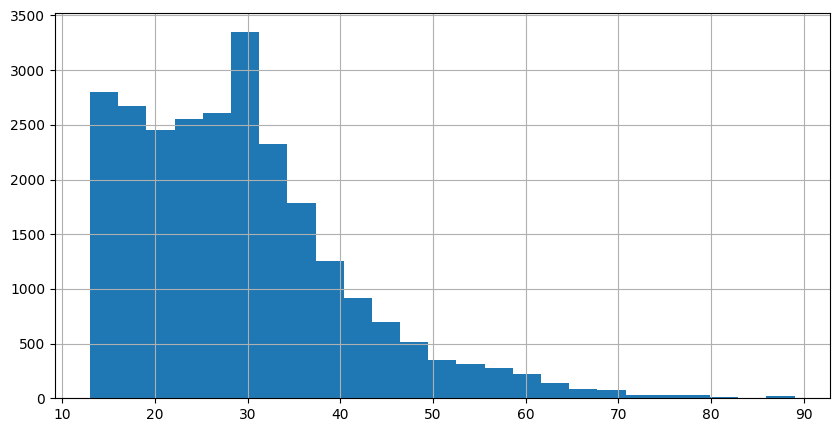

In [158]:
c_add_user_ds_subset["age"].hist(bins=25, figsize=(10, 5))

In [159]:
# Вносим в наш датасет найденные значения
mask = с_add_user_ds['user_id'].isin(c_add_user_ds_subset['user_id'])
с_add_user_ds.loc[mask, "age"] = c_add_user_ds_subset["age"]

<Axes: >

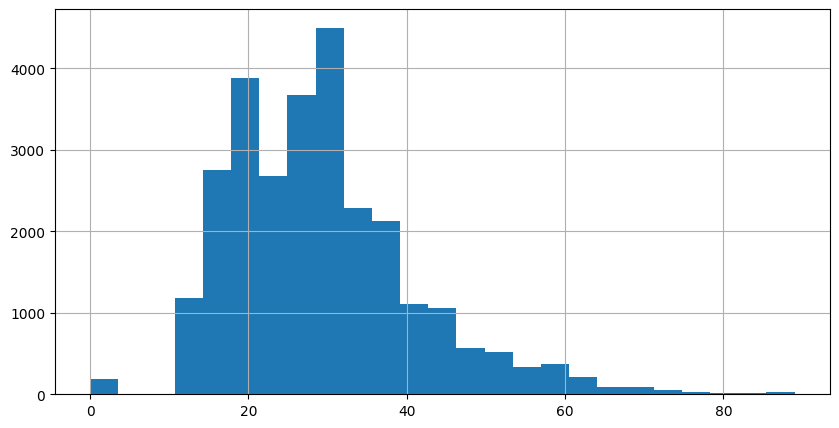

In [160]:
с_add_user_ds["age"].hist(bins=25, figsize=(10, 5))

In [163]:
с_add_user_ds[с_add_user_ds["age"] == 0]

,user_id,sex,age,city_id,publisher_quantity,views,top_time_interval_8-15,top_time_interval_16-21,top_time_interval_22-7,top_time_interval_ratio,is_workday,top_publisher,top_publisher_ratio
10,10,0,0,8479,0,0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,NaN
143,143,1,0,237,0,0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,NaN
317,317,1,0,8479,0,0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,NaN
351,351,0,0,308,0,0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,NaN
359,359,1,0,237,0,0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27428,27428,0,0,72,0,0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,NaN
27544,27544,0,0,8479,0,0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,NaN
27668,27668,1,0,8479,0,0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,NaN
27748,27748,1,0,8479,0,0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,NaN


# Preprocess

In [ ]:
# Define the data path and taget
dataset_path = os.path.join(INPUT_DATA_PATH, "name_of_file.csv")
label_name = "label_name"
# Define the transformers
feature_transform = Pipeline([
    ("normalizer", Normalizer()),
    ("scaler", StandardScaler())
])
target_transform = Pipeline([
    ("label_encoder", LabelEncoder())
])
# Create the dataset
train_dataset = CustomImageDataset(
    dataset_path=dataset_path,
    label_name=label_name,
    transform=feature_transform,
    target_transform=target_transform
)